In [9]:
from datetime import datetime
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt


/home/seixas/Documentos/ml pe/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

df = pd.read_csv('../data/brutos/resultado_pocos.csv', sep=';', encoding='latin-1')


In [7]:
def gerar_dados_sinteticos(df_original):
    np.random.seed(42)
    n = len(df_original)

    df_original['porosidade_pct'] = np.clip(np.random.normal(18, 4, n), 8, 28)
    df_original['espessura_zona_prod_m'] = np.random.uniform(5, 60, n)
    df_original['pressao_reservatorio_psi'] = np.random.lognormal(mean=8, sigma=0.6, size=n)
    df_original['pressao_reservatorio_psi'] = np.clip(df_original['pressao_reservatorio_psi'], 100, 5000)
    df_original['saturacao_oleo_pct'] = np.random.uniform(30, 85, n)

    litologias = ['Arenito', 'Folhelho', 'Calcário', 'Conglomerado']
    probs = [0.6, 0.25, 0.1, 0.05]
    df_original['litologia'] = np.random.choice(litologias, size=n, p=probs)

    df_original['produtividade_inicial_bpd'] = (
        0.8 * df_original['porosidade_pct'] +
        1.2 * df_original['espessura_zona_prod_m'] +
        0.015 * df_original['pressao_reservatorio_psi'] +
        np.random.normal(0, 20, n)
    )

    df_original['produtividade_inicial_bpd'] = df_original['produtividade_inicial_bpd'].clip(lower=50)

    return df_original

# Gere novamente o df_sintetico
df_sintetico = gerar_dados_sinteticos(df)


In [8]:
curvas = []

for idx, row in df_sintetico.iterrows():
    curva = simular_curva_producao(
        poco_id=row['Nome Poço ANP'],
        bpd_inicial=row['produtividade_inicial_bpd'],
        declinio=np.random.uniform(0.02, 0.08)
    )
    curvas.append(curva)

df_curvas = pd.concat(curvas, ignore_index=True)
df_curvas.head()


,poco_id,data,bpd
0,1-BGM-6-ES,2024-01-01,87.071230
1,1-BGM-6-ES,2024-02-01,84.917324
2,1-BGM-6-ES,2024-03-01,82.816700
3,1-BGM-6-ES,2024-04-01,80.768039
4,1-BGM-6-ES,2024-05-01,78.770057


A curva representa a produção mensal simulada de um poço usando declínio exponencial, com base na produtividade inicial gerada.

18:39:24 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing


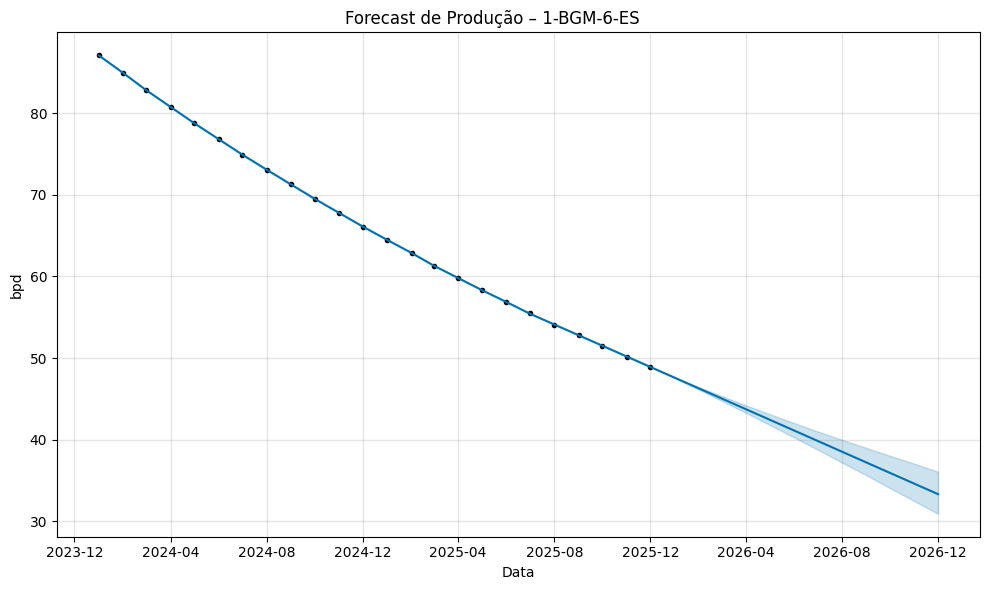

In [10]:
poco_exemplo = df_curvas['poco_id'].unique()[0]
df_poço = df_curvas[df_curvas['poco_id'] == poco_exemplo].copy()

# Renomeia colunas para formato do Prophet
df_prophet = df_poço.rename(columns={'data': 'ds', 'bpd': 'y'})

# Modelo
modelo = Prophet()
modelo.fit(df_prophet)

# Criar datas futuras
futuro = modelo.make_future_dataframe(periods=12, freq='MS')  # +12 meses

# Previsão
forecast = modelo.predict(futuro)

# Plot
fig = modelo.plot(forecast)
plt.title(f'Forecast de Produção – {poco_exemplo}')
plt.xlabel("Data")
plt.ylabel("bpd")
plt.tight_layout()
plt.show()

O gráfico mostra a produção simulada do poço ao longo do tempo com previsão para os 12 meses seguintes. A curva decrescente segue o comportamento natural de declínio da produção, comum em reservatórios sem estímulo. As faixas em cinza representam a incerteza estimada pelo modelo.